# 1. Mutation Indicator with SKLearn Models

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.image as img

# sklearn
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import tools
import os; os.chdir("..")
from tools.config   import TCGA_MUT,GENE2VEC,FIGURES
from tools.utils    import size,freememory
from tools.somatic  import process_labels,filter_variants,filter_genes, \
                           visualise_distributions, dedup, reshape_pivot, \
                           convert_to_onehot, get_label_df

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          name=None,
                          cmap=plt.cm.Blues,
                          savefig=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
            
    title = 'Confusion Matrices'

    # Compute confusion matrices
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
    # Initialise plot
    fig, axes = plt.subplots(ncols=2, figsize = (20,11))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.6)

    for i, ax in enumerate(axes):
        if i == 1:
            normalise = True
            data = cm_norm
            title = 'Normalised'
        else:
            normalise = False
            data = cm
            title = 'Non-Normalised'
            
        ax.imshow(data, interpolation='nearest')
        
#         ax.figure.colorbar()
        # We want to show all ticks...
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.1f' if normalise else 'd'
        thresh = data.max() / 2.
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt),
                        ha="center", va="center",
                        color="white" if data[i, j] < thresh else "black")
            
    fig.tight_layout()
    plt.show()
    
    if savefig:
        fig.savefig(FIGURES/'sklearn'/name.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
    

# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs=-1)
    
    train_scores = model_selection.cross_val_score(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs=-1)
    
    cv_proba = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  method='predict_proba',
                                                  n_jobs=-1)
    
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, train_scores, acc_cv, cv_proba

In [5]:
# Gradient Boosting Trees
def run_model(X_train, y_train, model, model_name, data_name, cv=10):
    import time; import datetime
    start_time = time.time()
    train_pred, train_scores, acc_cv, cv_proba = fit_ml_algo(model, 
                                               X_train, 
                                               y_train, 
                                               cv)
    gbt_time = (time.time() - start_time)
    
    print("Model: %s, DataFrame: %s" % (model_name, data_name))
    print("Accuracy CV 10-Fold: %s" % acc_cv)
    print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))
    
    print(metrics.classification_report(y_train, train_pred))
    
#     save_dir = EXP1_DIR + "{}_{}_".format(data_name, model_name)
    
#     # save model
#     with open(save_dir + "model.pkl", 'wb') as outfile:
#         pkl.dump(model, outfile)
    
#     # save scores
#     with open(save_dir + "scores.pkl", 'wb') as outfile:
#         pkl.dump((train_pred, acc_cv, cv_proba), outfile)
    
    return train_pred, train_scores, acc_cv, cv_proba

In [6]:
models2 = {
        'log' : {
            'model' : LogisticRegression(n_jobs = -1),
        },
    
        'sgd' : {
            'model' : CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', 
                                                                          max_iter=1, 
                                                                          n_jobs = -1), 
                                                                          method='sigmoid', 
                                                                          cv=10)
        },

        'rf' : {
            'model' : RandomForestClassifier(n_estimators=20, 
                                             min_samples_leaf=2,
                                             min_samples_split=17, 
                                             criterion='gini', 
                                             max_features=20,
                                             n_jobs=-1)
        },
    
        'gbt' : { 
            'model' : GradientBoostingClassifier(n_estimators=20, 
                                                 min_samples_leaf=2,
                                                 min_samples_split=17, 
                                                 max_features=20)
        }
    }

## Sample according to Intogen genes

Model: log, DataFrame: df_1
Accuracy CV 10-Fold: 48.78
Running Time: 0:00:07.690131
                precision    recall  f1-score   support

MERGE-COADREAD       0.73      0.77      0.75       534
  MERGE-GBMLGG       0.64      0.72      0.68       876
    MERGE-STES       0.26      0.22      0.24       613
      TCGA-ACC       0.38      0.07      0.11        75
     TCGA-BLCA       0.57      0.51      0.54       409
     TCGA-BRCA       0.42      0.65      0.51       961
     TCGA-CESC       0.28      0.20      0.23       286
     TCGA-CHOL       0.27      0.06      0.10        48
     TCGA-DLBC       0.58      0.19      0.29        37
     TCGA-HNSC       0.38      0.37      0.37       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.74      0.71      0.73       324
     TCGA-KIRP       0.22      0.19      0.21       254
     TCGA-LAML       0.65      0.43      0.52       127
     TCGA-LIHC       0.39      0.33      0.35       353
     TCGA-LUAD     

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


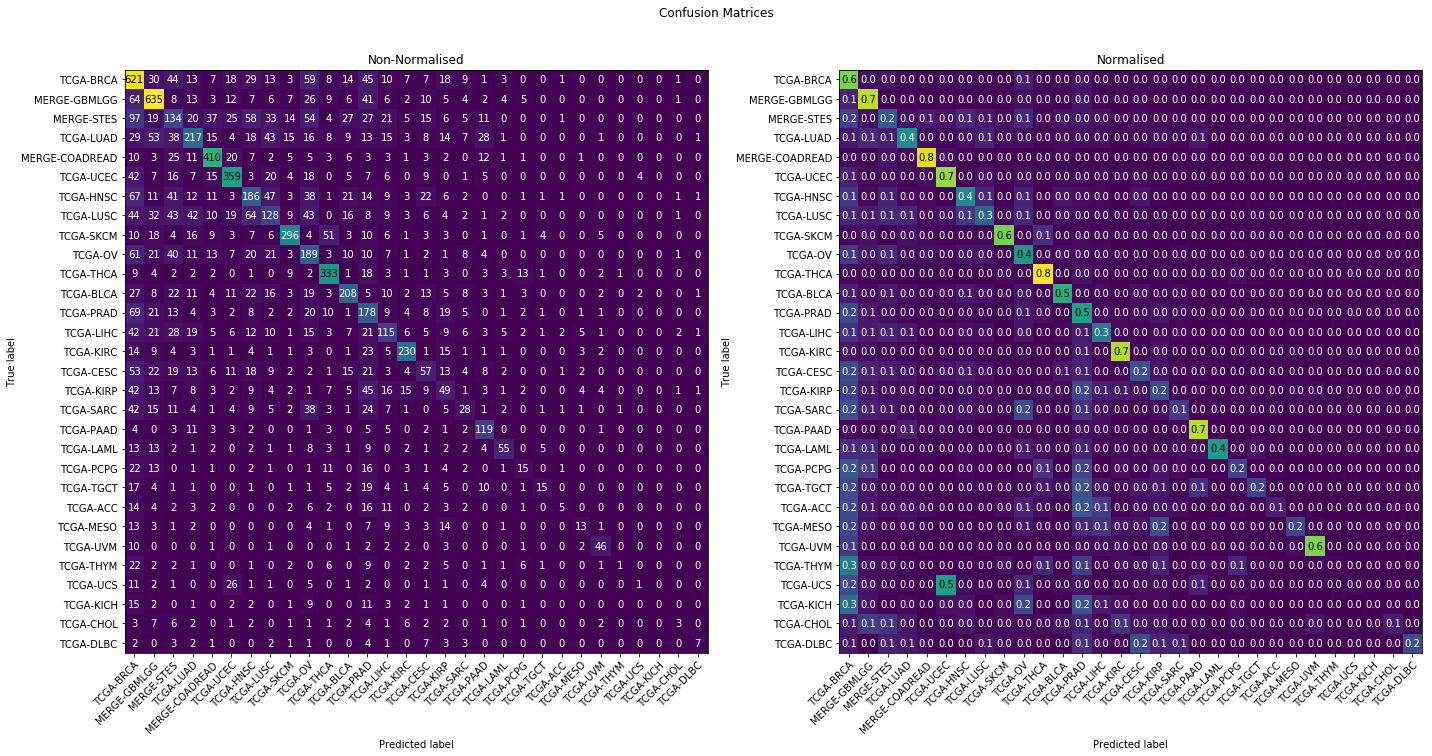

Model: sgd, DataFrame: df_1
Accuracy CV 10-Fold: 46.25
Running Time: 0:00:14.201581
                precision    recall  f1-score   support

MERGE-COADREAD       0.65      0.79      0.71       534
  MERGE-GBMLGG       0.57      0.72      0.64       876
    MERGE-STES       0.23      0.10      0.14       613
      TCGA-ACC       0.00      0.00      0.00        75
     TCGA-BLCA       0.54      0.55      0.54       409
     TCGA-BRCA       0.27      0.76      0.40       961
     TCGA-CESC       0.25      0.02      0.04       286
     TCGA-CHOL       0.00      0.00      0.00        48
     TCGA-DLBC       1.00      0.05      0.10        37
     TCGA-HNSC       0.38      0.39      0.38       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.76      0.70      0.73       324
     TCGA-KIRP       0.43      0.08      0.13       254
     TCGA-LAML       0.78      0.25      0.38       127
     TCGA-LIHC       0.52      0.31      0.39       353
     TCGA-LUAD     

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


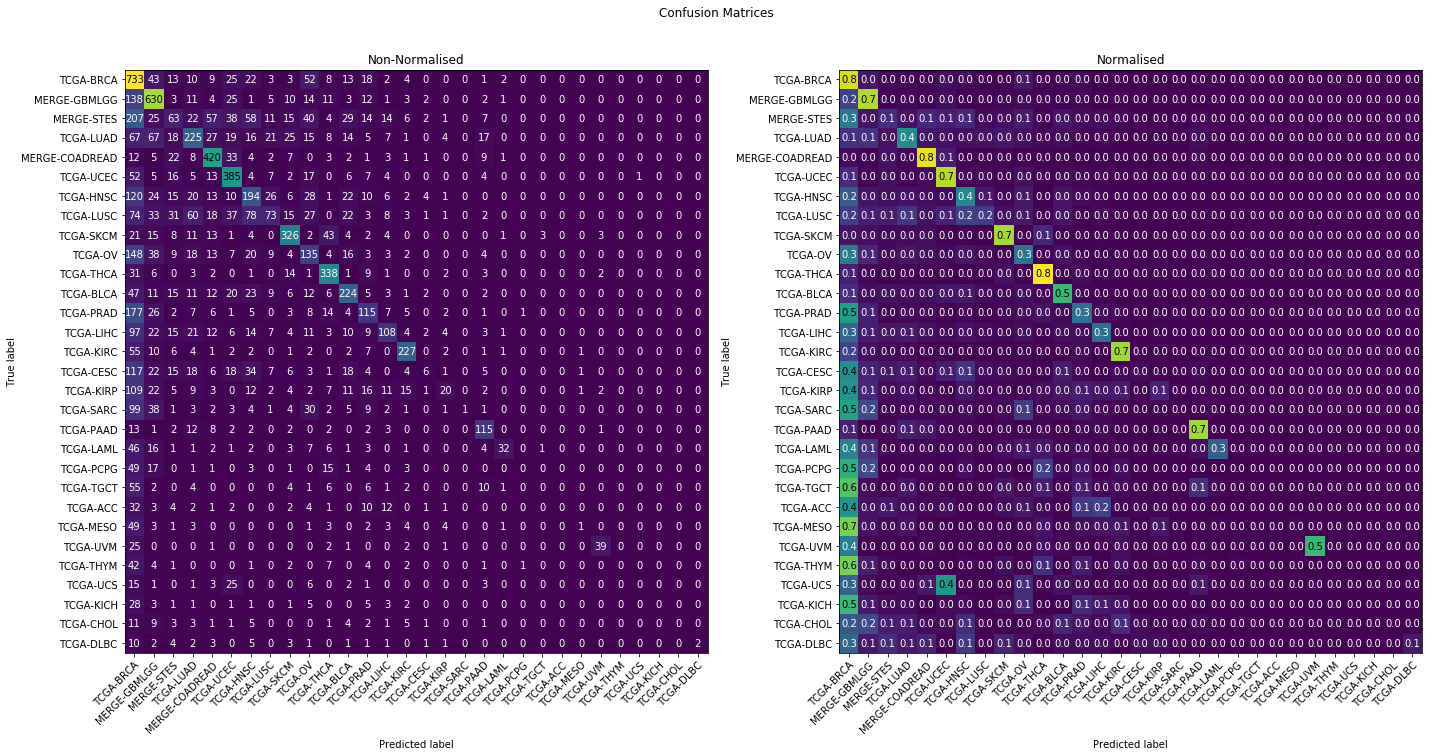

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model: rf, DataFrame: df_1
Accuracy CV 10-Fold: 48.33
Running Time: 0:00:05.361398
                precision    recall  f1-score   support

MERGE-COADREAD       0.65      0.78      0.71       534
  MERGE-GBMLGG       0.59      0.75      0.66       876
    MERGE-STES       0.23      0.14      0.18       613
      TCGA-ACC       0.11      0.03      0.04        75
     TCGA-BLCA       0.52      0.40      0.45       409
     TCGA-BRCA       0.45      0.63      0.53       961
     TCGA-CESC       0.29      0.14      0.19       286
     TCGA-CHOL       0.00      0.00      0.00        48
     TCGA-DLBC       0.00      0.00      0.00        37
     TCGA-HNSC       0.40      0.36      0.38       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.67      0.73      0.70       324
     TCGA-KIRP       0.26      0.18      0.21       254
     TCGA-LAML       0.51      0.34      0.41       127
     TCGA-LIHC       0.44      0.30      0.36       353
     TCGA-LUAD      

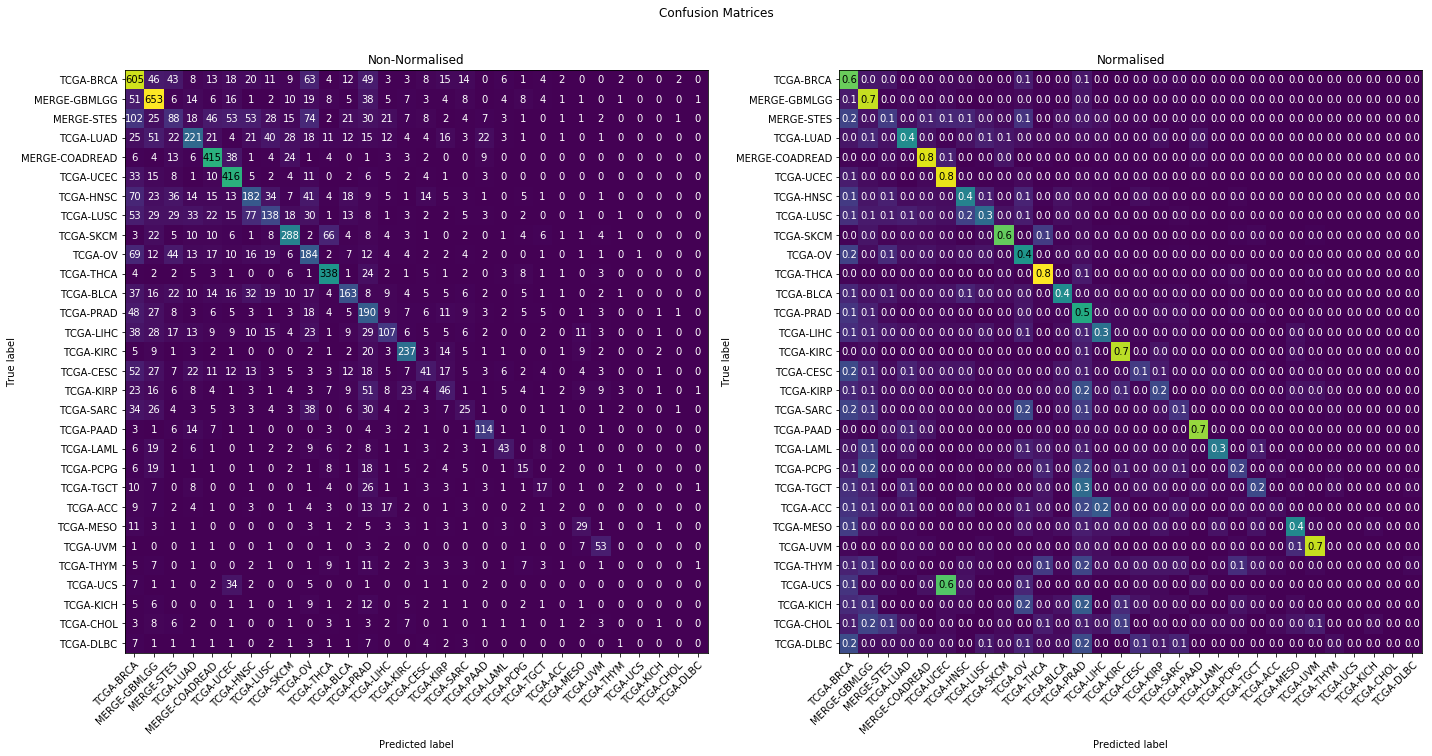

Model: gbt, DataFrame: df_1
Accuracy CV 10-Fold: 38.96
Running Time: 0:00:20.831785
                precision    recall  f1-score   support

MERGE-COADREAD       0.57      0.68      0.62       534
  MERGE-GBMLGG       0.43      0.68      0.52       876
    MERGE-STES       0.26      0.11      0.15       613
      TCGA-ACC       0.00      0.00      0.00        75
     TCGA-BLCA       0.55      0.38      0.45       409
     TCGA-BRCA       0.21      0.81      0.33       961
     TCGA-CESC       0.25      0.01      0.02       286
     TCGA-CHOL       0.00      0.00      0.00        48
     TCGA-DLBC       0.50      0.05      0.10        37
     TCGA-HNSC       0.43      0.31      0.36       502
     TCGA-KICH       0.00      0.00      0.00        51
     TCGA-KIRC       0.75      0.64      0.69       324
     TCGA-KIRP       0.30      0.01      0.02       254
     TCGA-LAML       0.67      0.13      0.21       127
     TCGA-LIHC       0.58      0.23      0.33       353
     TCGA-LUAD     

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


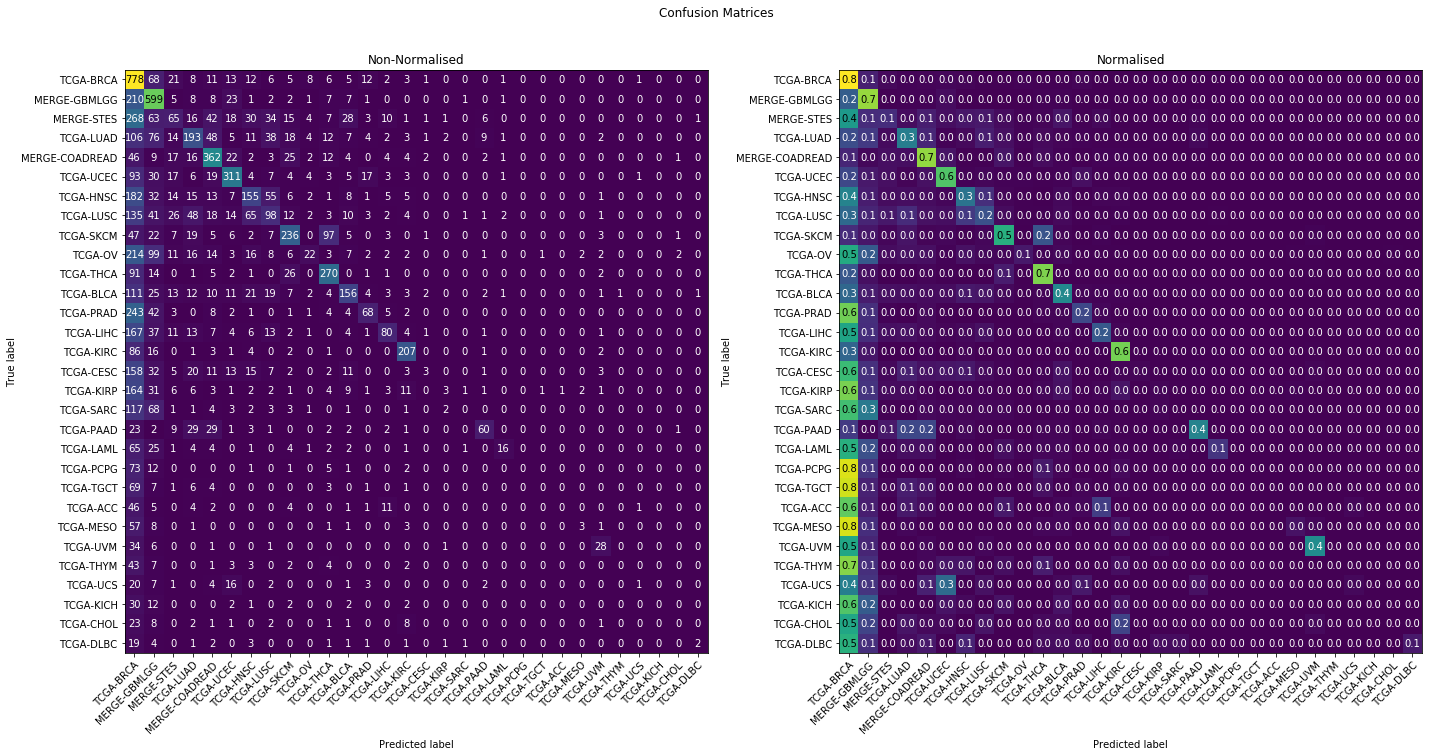

In [12]:
# load data
import pandas as pd
df_tcga = pd.read_csv(TCGA_MUT)

# process and filter
df_X    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='intogen', number=459)
                  .pipe(dedup)
                  .pipe(reshape_pivot))

df_y    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='intogen', number=459)
                  .pipe(get_label_df, df_X))

df_somatic = convert_to_onehot(df_X)

for name, model in models2.items():
    model['train_pred'], model['train_scores'], \
    model['acc_cv'], model['cv_proba'] = run_model(df_X, df_y.values.ravel(), model['model'], name, 'df_1')
    plot_confusion_matrix(df_y, 
                          model['train_pred'], 
                          classes=df_y['project_short_name'].value_counts().index.values,
                          name=name)

## Sample according to MutSigCV driver subset

In [ ]:
# load data
import pandas as pd
df_tcga = pd.read_csv(TCGA_MUT)

# process and filter
df_X    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1000)
                  .pipe(dedup)
                  .pipe(reshape_pivot))

df_y    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1000)
                  .pipe(get_label_df, df_X))

df_somatic = convert_to_onehot(df_X)

for name, model in models2.items():
    model['train_pred'], model['train_scores'], \
    model['acc_cv'], model['cv_proba'] = run_model(df_X, df_y.values.ravel(), model['model'], name, 'df_1')
    plot_confusion_matrix(df_y, 
                          model['train_pred'], 
                          classes=df_y['project_short_name'].value_counts().index.values,
                          name=name)

## Sample according to 2020+ cancer driver gene subset

In [7]:
models3 = {
        'log' : {
            'model' : LogisticRegression(n_jobs = -1),
        },
    
        'sgd' : {
            'model' : CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge', 
                                                                          max_iter=1, 
                                                                          n_jobs = -1), 
                                                                          method='sigmoid', 
                                                                          cv=10)
        },

        'rf' : {
            'model' : RandomForestClassifier(n_estimators=20, 
                                             min_samples_leaf=2,
                                             min_samples_split=17, 
                                             criterion='gini', 
                                             max_features=20,
                                             n_jobs=-1)
        },
    
        'gbt' : { 
            'model' : GradientBoostingClassifier(n_estimators=20, 
                                                 min_samples_leaf=2,
                                                 min_samples_split=17, 
                                                 max_features=20)
        }
    }

In [ ]:
# load data
import pandas as pd
df_tcga = pd.read_csv(TCGA_MUT)

# process and filter
df_X    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='2020+', number=1000)
                  .pipe(dedup)
                  .pipe(reshape_pivot))

df_y    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='2020+', number=1000)
                  .pipe(get_label_df, df_X))

df_somatic = convert_to_onehot(df_X)

for name, model in models3.items():
    model['train_pred'], model['train_scores'], \
    model['acc_cv'], model['cv_proba'] = run_model(df_X, df_y.values.ravel(), model['model'], name, 'df_1')
    plot_confusion_matrix(df_y, 
                          model['train_pred'], 
                          classes=df_y['project_short_name'].value_counts().index.values,
                          name=name)

Text(0.5, 0, 'Classifier Type')

Text(0, 0.5, 'Accuracy CV (%)')

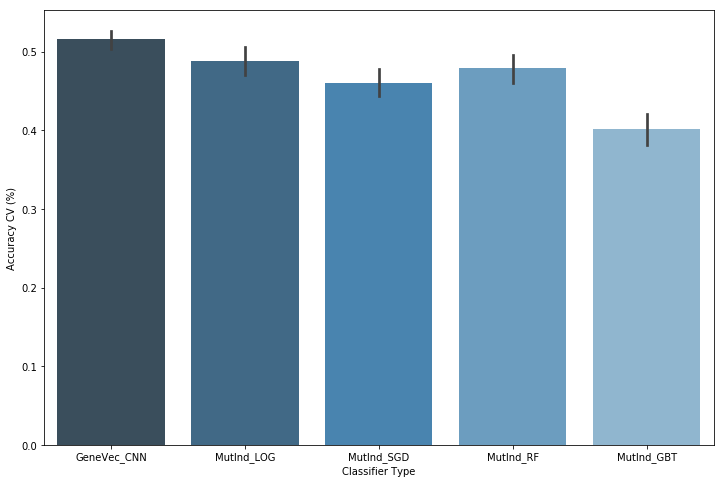

In [24]:
dfs = []

dict_ = {'model':'GeneVec_CNN', 'score':[0.491,0.516,0.523,0.521,0.532]}
dfs.append(pd.DataFrame(dict_))

for name, model in models2.items():
    dict_ = {'model':'MutInd_'+name.upper(), 'score':model['train_scores']}
    dfs.append(pd.DataFrame(dict_))
        
results = pd.concat(dfs)
fig, ax = plt.subplots(1, 1, figsize=(12,8));
import seaborn as sns
ax = sns.barplot(x="model", y="score", data=results, palette='Blues_d')
ax.set_xlabel('Classifier Type'); ax.set_ylabel('Accuracy CV (%)')
fig.savefig(FIGURES/'accuracy_cv.png')

In [83]:
def print_confusion_matrix(confusion_matrix, class_names, fontsize=14, ax=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=False, fmt="d", cmap="Blues", cbar=False, ax=ax)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylabel('True label')
    heatmap.set_xlabel('Predicted label')
    return heatmap

# # Compute confusion matrices
# classes = df_y['project_short_name'].value_counts().index.values
# cm = confusion_matrix(df_y, models3['log']['train_pred'], 
#                       labels=classes)
# cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100).astype('int')

# fig = plt.figure(figsize=(16,12))
# print_confusion_matrix(cm_percent, classes)
# fig.savefig(FIGURES/'cm_log.png')

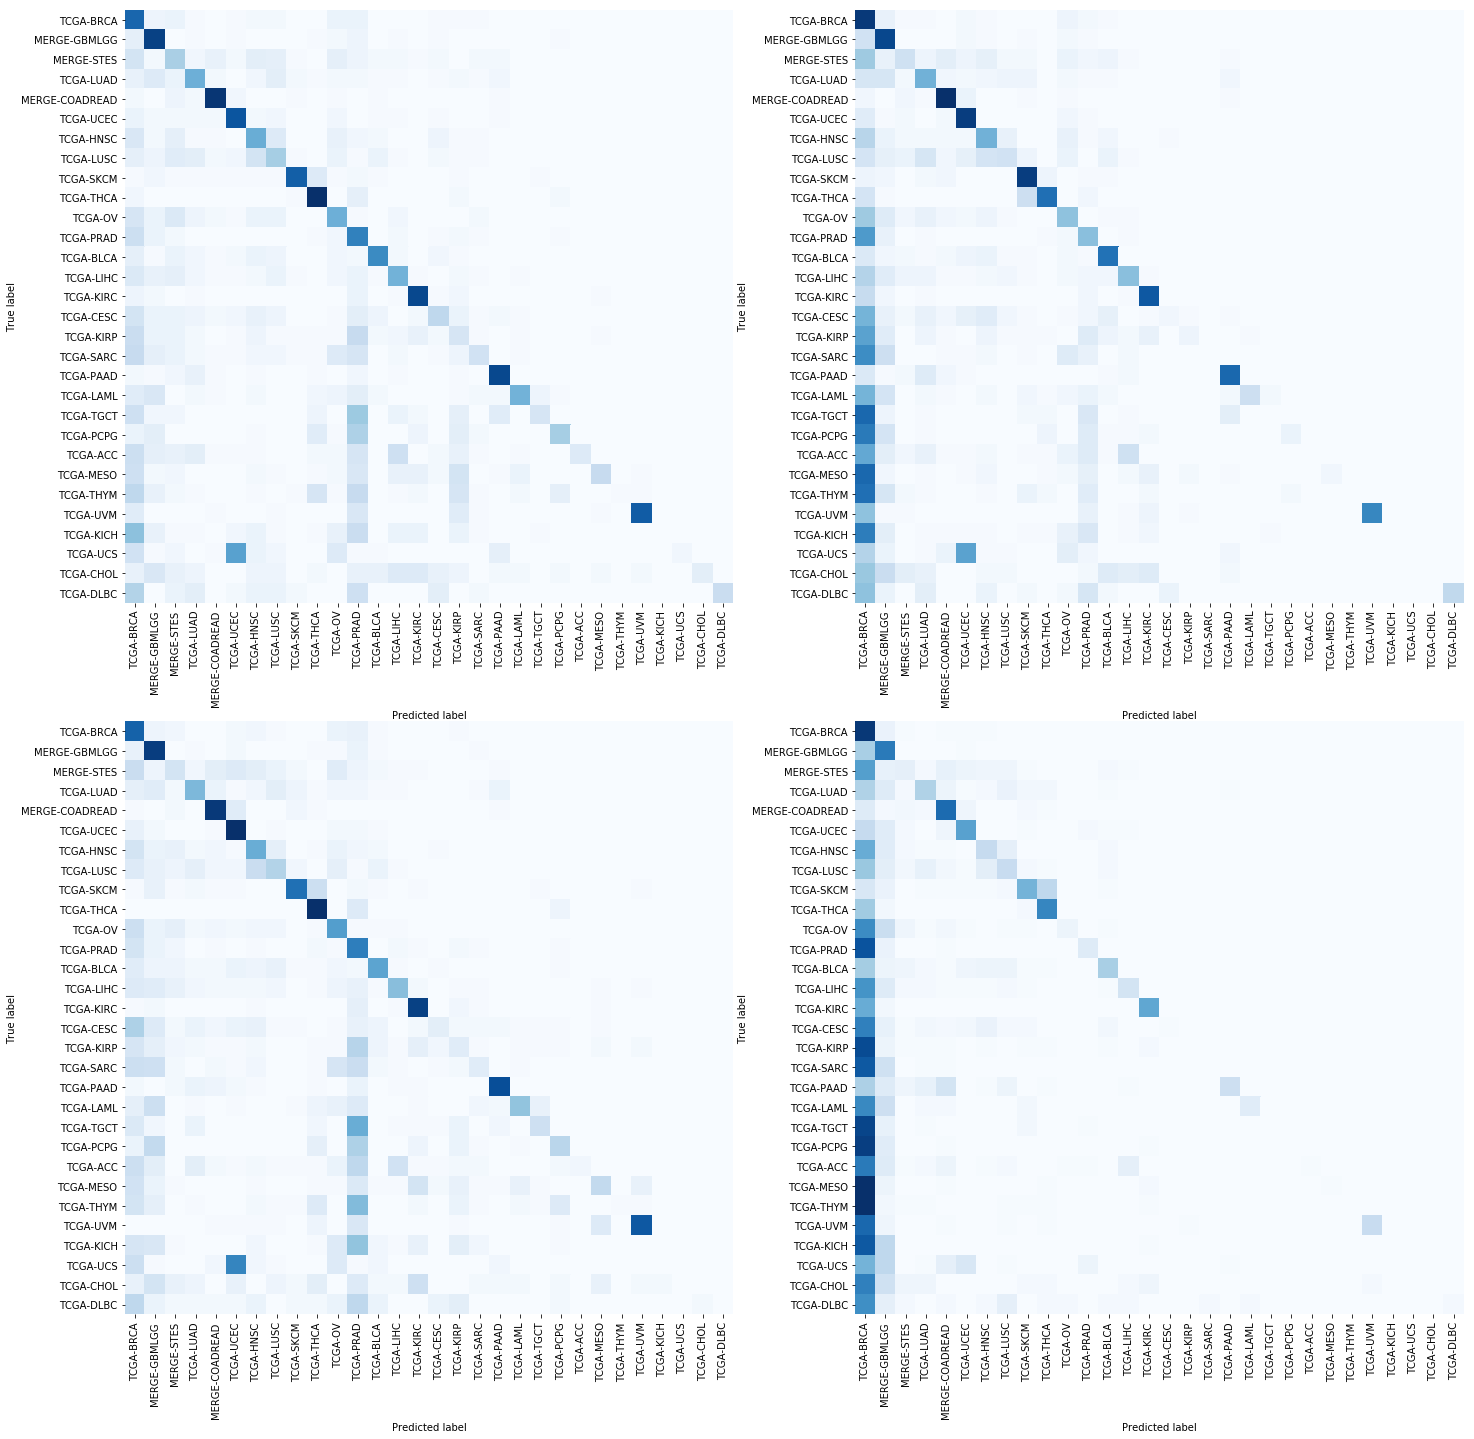

In [84]:
fig,axs = plt.subplots(2,2,figsize=(24,24))

for i, name in enumerate(models3.keys()):
    classes = df_y['project_short_name'].value_counts().index.values
    cm = confusion_matrix(df_y, models3[name]['train_pred'], labels=classes)
    cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100).astype('int')
    print_confusion_matrix(cm_percent, classes, ax=axs[i//2,i%2])
fig.savefig(FIGURES/'cm_all.png',bbox_inches='tight', pad_inches=0.5)

---

In [ ]:
# import xgboost

# # sample all data, no filter
# import pandas as pd
# df_tcga = pd.read_csv(TCGA_MUT)

# # process and filter
# df_X    = (df_tcga.pipe(process_labels)
#                   .pipe(filter_variants)
#                   .pipe(dedup)
#                   .pipe(reshape_pivot))

# df_y    = (df_tcga.pipe(process_labels)
#                   .pipe(filter_variants)
#                   .pipe(get_label_df, df_X))

# # load JS visualization code to notebook
# shap.initjs()

# # label encode y values
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# y_enc = le.fit_transform(df_y.values.ravel())

# # train XGBoost model
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(df_X, label=y_enc), 100)

In [ ]:
# import shap

# # explain the model's predictions using SHAP values
# models2['rf']['model'].fit(df_X, df_y.values.ravel())
# explainer = shap.TreeExplainer(models2['rf']['model'])
# shap_values = explainer.shap_values(df_X)

In [ ]:
pos=np.sum(np.mean(np.asarray(shap_values).clip(min=0), axis=0), axis=0)

In [ ]:
neg=np.sum(np.mean(np.asarray(shap_values).clip(max=0), axis=0), axis=0)

In [ ]:
preds = models2['rf']['model'].predict(df_X)
from sklearn.metrics import accuracy_score

# preds = [round(value) for value in preds]
accuracy = accuracy_score(df_y, preds)
print("Training accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
genes = df_X.columns
cum_shap = np.sum(shap_sum, 0)
data_pos = pd.Series(pos, index=genes).sort_values(ascending=False)
data_neg = pd.Series(neg, index=genes).sort_values(ascending=False)

# .apply(lambda x : np.abs(x))

data_df_pos = pd.DataFrame({'Gene':data_pos.index, 'Cumulative SHAP Score':data_pos.values})
data_df_neg = pd.DataFrame({'Gene':data_neg.index, 'Cumulative SHAP Score':data_neg.values})

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,8))
import seaborn as sns
ax[0] = sns.barplot(x='Gene', y='Cumulative SHAP Score', data=data_df_pos.head(50), ax=ax[0], palette='Reds_d')
ax[1] = sns.barplot(x='Gene', y='Cumulative SHAP Score', data=data_df_neg.head(50), palette='Blues_d')
_=plt.setp(ax[0].get_xticklabels(), rotation=60); _=plt.setp(ax[1].get_xticklabels(), rotation=45)

fig.tight_layout(); fig.subplots_adjust(top=0.9); fig.show()
# ax[0].set_yscale('symlog'); ax[1].set_yscale('symlog')
fig.savefig(FIGURES/'SHAP_results.png')

---